In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import joblib
import sklearn

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# AutoML
from autofeat import AutoFeatClassifier, AutoFeatRegressor, FeatureSelector
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import f1 as autosklearn_f1

# Clustering
from sklearn.cluster import KMeans
import spacy

# Tuning and evaluation
from edawesome.sklearn_help import pretty_classification_report
import optuna
from tqdm import tqdm
from sklearn.metrics import make_scorer, f1_score
import shap


# Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC

from functools import partial

In [2]:
SEED = 42

In [3]:
status_df = pd.read_csv(os.path.join('data', 'downsampled_data', 'part-00000-2ccbea9d-88f8-498a-b0b9-bc5808ac195f-c000.csv'))
status_df

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,SUM(bureau.amt_credit_sum_debt),SUM(bureau.amt_credit_sum_limit),SUM(bureau.amt_credit_sum_overdue),SUM(bureau.cnt_credit_prolong),SUM(bureau.credit_day_overdue),SUM(bureau.days_credit),SUM(bureau.days_credit_enddate),SUM(bureau.days_credit_update),SUM(bureau.days_enddate_fact),sk_id_curr
0,0,Revolving loans,M,Y,N,0,450000.0,900000.0,45000.0,900000.0,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100474
1,0,Cash loans,M,Y,N,1,225000.0,942300.0,24984.0,675000.0,...,79038.000,0.000,0.0,0.0,0.0,-6453.0,-2435.0,-3532.0,-4108.0,100673
2,0,Cash loans,M,Y,Y,0,112500.0,90000.0,9351.0,90000.0,...,1252521.000,0.000,0.0,0.0,0.0,-1519.0,1403.0,-156.0,-222.0,100847
3,0,Cash loans,F,N,Y,0,112500.0,900000.0,26316.0,900000.0,...,103879.710,0.000,0.0,0.0,0.0,-1444.0,688.0,-76.0,0.0,101011
4,0,Cash loans,F,N,Y,0,202500.0,540000.0,25978.5,540000.0,...,72234.000,0.000,0.0,0.0,0.0,-1372.0,14.0,-373.0,-383.0,101328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49633,1,Cash loans,M,N,Y,0,90000.0,521280.0,35392.5,450000.0,...,0.000,0.000,0.0,0.0,0.0,-1417.0,409.0,-112.0,-1141.0,453131
49634,1,Revolving loans,F,N,N,0,225000.0,270000.0,13500.0,270000.0,...,0.000,0.000,0.0,0.0,0.0,-12521.0,22600.0,-6098.0,-10476.0,453420
49635,1,Cash loans,F,N,N,0,180000.0,1125000.0,30168.0,1125000.0,...,1073183.040,57.960,0.0,0.0,0.0,-16679.0,27741.0,-10783.0,-9923.0,454785
49636,1,Cash loans,F,Y,Y,0,216000.0,1082214.0,31770.0,945000.0,...,482557.500,0.000,0.0,0.0,0.0,-5631.0,92678.0,-2325.0,-1343.0,455068


In [4]:
not_treated = pickle.load(open(os.path.join('data', 'not_treated.pickle'), 'rb'))
not_treated

('occupation_type', 'organization_type')

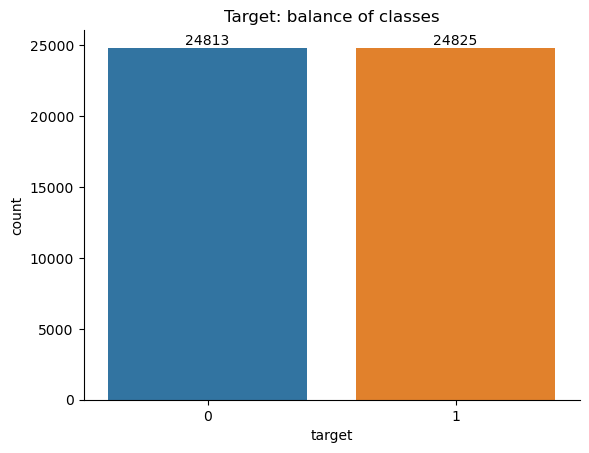

In [5]:
sns.countplot(
    data=status_df,
    x='target'
)

plt.bar_label(plt.gca().containers[0])
plt.title('Target: balance of classes')
sns.despine()
plt.show()

# Loan repayment status

In [6]:
def custom_metric(true_class, predicted_class, amt_credit, interest_rate=0.1, not_paid_rate=0.05, decimal_places_num=6):

    if decimal_places_num > 6:
        raise ValueError('decimal_places_num must be less or equal to 6')

    # Is false positive
    # We predict a loan will be repaid, but it actually isn't repaid
    fp = (predicted_class == 0) & (true_class == 1)

    # Is false negative
    # We predict a loan won't be repaid, but it actually is repaid
    fn = (predicted_class == 1) & (true_class == 0)

    # Price of false positive error
    fp_cost = fp * amt_credit * not_paid_rate

    # Price of false negative error
    fn_cost = fn * amt_credit * interest_rate

    # Total cost
    total_cost = (fp_cost + fn_cost).sum()
    
    # Maximum total cost with dummy prediction, when we predict all loans will be repaid
    max_cost = ((true_class == 1) * amt_credit).sum() * not_paid_rate

    # Calculate the score and round it to maximum 6 decimal places
    # Rounding is needed to avoid not exact floating point calculations
    score = 1 / (1 + total_cost / max_cost)
    score = round(score, decimal_places_num)

    return score

### Feature engineering

##### Ratio features

After exploring column descripttions, I've came up with 12 useful pairs of columns, which can be used to create new ratio features:

1) AMT_INCOME_TOTAL and AMT_CREDIT: This ratio could be useful for understanding the relative size of a loan relative to a borrower's income

2) AMT_INCOME_TOTAL and AMT_ANNUITY: This ratio could be useful for understanding the relative size of a borrower's annual payments relative to their income

3) AMT_CREDIT and AMT_ANNUITY: This ratio could be useful for understanding the relative size of a borrower's credit relative to their annual payments

4) DAYS_BIRTH and DAYS_EMPLOYED: This ratio could be useful for understanding the relative age of a borrower at the time of their loan application relative to the length of their employment\

5) AMT_CREDIT and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of a loan relative to the price of the goods being purchased with the loan

6) AMT_INCOME_TOTAL and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of the goods being purchased with the loan relative to a borrower's income

7) AMT_ANNUITY and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of the goods being purchased with the loan relative to a borrower's annual payments

8) CNT_FAM_MEMBERS and CNT_CHILDREN: This ratio could be useful for understanding the relative number of family members and children in a borrower's household

9) AMT_CREDIT and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of a loan relative to the price of the goods being purchased with the loan

10) AMT_REQ_CREDIT_BUREAU_YEAR and AMT_REQ_CREDIT_BUREAU_MON: This ratio could be useful for understanding the relative number of credit inquiries made by a borrower over the past year relative to the past month

11) AMT_CREDIT and AMT_REQ_CREDIT_BUREAU_YEAR: This ratio could be useful for understanding the relative size of a borrower's credit relative to the number of credit inquiries made by the borrower over the past year

12) AMT_INCOME_TOTAL and AMT_REQ_CREDIT_BUREAU_YEAR: This ratio could be useful for understanding the relative size of a borrower's income relative to the number of credit inquiries made by the borrower over the past year

In [7]:
class RatioFeaturesGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, ratio_columns):
        self.ratio_columns = ratio_columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        X = data.copy()
        for col1, col2 in self.ratio_columns:
            
            ratio_col = f'{col1}_{col2}_ratio'
            X[ratio_col] = X[col1] / X[col2]

            # Replace infinities with nan
            X[ratio_col] = X[ratio_col].replace([np.inf, -np.inf], np.nan)

            # Replace nans with the mean of the column
            X[ratio_col] = X[ratio_col].fillna(X[ratio_col].mean())

        return X

    def get_feature_names_out(self, input_features=None):
    
        if input_features is None:
            input_features = self.X.columns.tolist()

        return input_features

In [8]:
ratio_columns = [
    ('amt_income_total', 'amt_credit'),
    ('amt_income_total', 'amt_annuity'),
    ('amt_credit', 'amt_annuity'),
    ('days_birth', 'days_employed'),
    ('amt_credit', 'amt_goods_price'),
    ('amt_income_total', 'amt_goods_price'),
    ('amt_annuity', 'amt_goods_price'),
    ('cnt_fam_members', 'cnt_children'),
    ('amt_credit', 'amt_goods_price'),
    ('amt_req_credit_bureau_year', 'amt_req_credit_bureau_mon'),
    ('amt_credit', 'amt_req_credit_bureau_year'),
    ('amt_income_total', 'amt_req_credit_bureau_year'),
]

In [9]:
for pair in ratio_columns:
    for col in pair:
        status_df[col] = status_df[col].astype('float')
# we need this conversion, because some of the numeric columns were treated as categorical

##### Polynomial features

It's better to automatically generate polynomial features, so we will do it after training some models.

### Split into train and test

In [10]:
X = status_df.drop(['ext_source_1', 'ext_source_2', 'ext_source_3', 'target'], axis='columns')
y, amt_credit = status_df.target, status_df.amt_credit

# check missing values in target
y.isna().sum()

# convert target to int
y = y.astype(int)

X_train, X_test, y_train, y_test, amt_credit_train, amt_credit_test = train_test_split(
    X, y, amt_credit, test_size=0.2, random_state=SEED
)

### Not treated features

In [11]:
# Create a function which creates a cluster column to add to the pipeline

def create_cluster_column(column, n_clusters=5, random_state=SEED):

        # convert to pandas series and get unique values
        column = pd.Series(column, name='COLUMN')
        words = column.unique()

        # tokenize and vectorize with SpaCy
        nlp = spacy.load('en_core_web_sm')
        tokens = [nlp(str(elem)) for elem in words]
        vectors = [token.vector for token in tokens]
        
        # cluster with kmeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(vectors)
        clusters = kmeans.labels_

        # create a dataframe with the clusters
        clusters_df = pd.DataFrame({'COLUMN': column.unique(), 'cluster': clusters})

        # when value is "Not provided", make cluster = -1
        clusters_df.loc[clusters_df['COLUMN'] == 'Not provided', 'cluster'] = -1

        # merge the clusters with the original dataframe
        merged_df = column.to_frame().merge(clusters_df, on='COLUMN', how='left')
    
        return merged_df.cluster

In [12]:
# Create a custom transformer using the function above
class Cluster(BaseEstimator, TransformerMixin):

    def __init__(self, n_clusters=5, random_state=SEED, col_names=None):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.col_names = col_names

    def fit(self, data, y=None):
        return self

    def transform(self, data, y=None):

        data = data.copy()

        for col in self.col_names:
            cluster_name = col + '_cluster'
            data[cluster_name] = create_cluster_column(X[col], self.n_clusters, self.random_state)
            data[cluster_name] = data[cluster_name].astype('str')

        return data

    def get_feature_names_out(self, input_features=None):
        
        if input_features is None:
            input_features = self.data.columns.tolist()

        return input_features

### Preparation pipeline

In [13]:
# numerical pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('ratios', RatioFeaturesGenerator(ratio_columns))
])

# categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not provided')),
    ('clustering', Cluster(col_names=not_treated)),
    ('categorical_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# create pipeline for predictors
encoding_col_transformer = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, selector(dtype_include ='number')),
    ('categorical_transformer', categorical_transformer, selector(dtype_exclude='number'))
], remainder='passthrough')

In [14]:
encoding_col_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('ratios',
                                                  RatioFeaturesGenerator(ratio_columns=[('amt_income_total',
                                                                                         'amt_credit'),
                                                                                        ('amt_income_total',
                                                                                         'amt_annuity'),
                                                                                        ('amt_credit',
                                                                                         'amt_annuity'),
                                                                                        ('days_birth',
                                                                                         'days_employed'),
                                                                                        ('amt...
                                ('categorical_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Not '
                                                                           'provided',
                                                                strategy='constant')),
                                                 ('clustering',
                                                  Cluster(col_names=('occupation_type',
                                                                     'organization_type'))),
                                                 ('categorical_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a1d089c40>)])

In [15]:
X_train_prepared = encoding_col_transformer.fit_transform(X_train)

/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/dreamtim/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain 

In [16]:
X_test_prepared = encoding_col_transformer.transform(X_test)

/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/dreamtim/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain 

### Rebalance test data to the original distribution

In [17]:
# TODO: save this snippet
def resample_data(X, y, additional_columns, sampler, sampler_params):
    # Create a Pandas DataFrame with the feature columns (X), target labels (y), and additional columns (additional_columns)
    df = X.copy()
    df['target'] = y
    for col_name, col_values in additional_columns.items():
        df[col_name] = col_values

    # Create an instance of the resampling method
    resampler = sampler(**sampler_params)

    # Use the fit_resample method to resample the data
    X_resampled, y_resampled = resampler.fit_resample(df, y)

    # Create a dictionary of resampled additional columns
    additional_columns_resampled = {}
    for col_name, col_values in additional_columns.items():
        additional_columns_resampled[col_name] = X_resampled[col_name]

    return X_resampled, y_resampled, additional_columns_resampled

In [18]:
# rebalance the test data to the original distribution

counts = y_test.value_counts()
n_0 = counts[0]
n_1 = counts[1]

n_1 = int(n_0 * 0.1)

X_test_resampled, y_test_resampled, additional_columns = resample_data(
    X_test_prepared, y_test, {'amt_credit': amt_credit_test},
    RandomUnderSampler, {'sampling_strategy': {0: n_0, 1: n_1}, 'random_state': SEED}
)

amt_credit_test_resampled = additional_columns['amt_credit']

### Autosklearn baseline

In [20]:
automl = AutoSklearnClassifier(
    time_left_for_this_task=5*15*60,
    per_run_time_limit=15*60,
    memory_limit=8000,
    resampling_strategy='cv',
    resampling_strategy_arguments={'folds': 5},
    metric=autosklearn_f1,
    seed=SEED
)

In [21]:
automl.fit(X_train_prepared, y_train)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=8000, metric=f1, per_run_time_limit=900,
                      resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 5}, seed=42,
                      time_left_for_this_task=4500)

/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/dreamtim/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain 

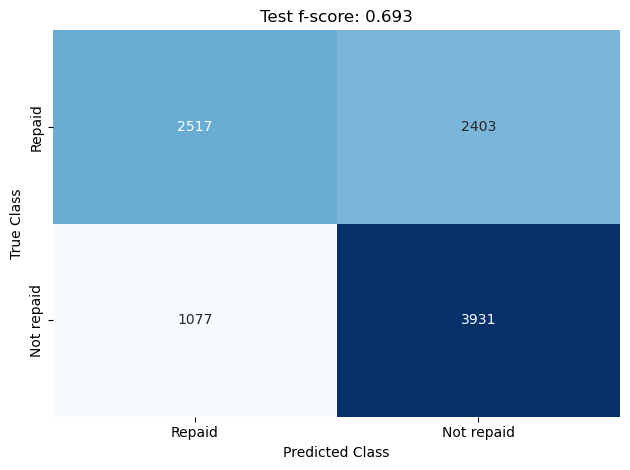

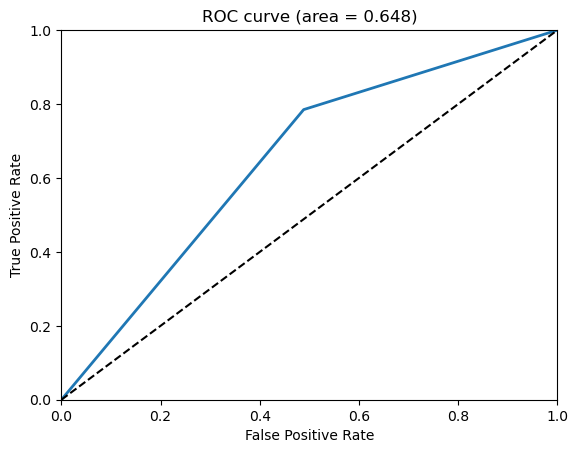

In [22]:
pretty_classification_report(
    estimator=automl,
    X=encoding_col_transformer.transform(X_test),
    y=y_test,
    class_names=['Repaid', 'Not repaid'],
    how='test'
)

In [34]:
automl_predictions = automl.predict(X_test_resampled)
custom_metric(y_test_resampled, automl_predictions, amt_credit_test_resampled)

0.091991

In [35]:
automl_predictions = automl.predict(X_test_prepared)
custom_metric(y_test, automl_predictions, amt_credit_test)

0.455306

**Worse than just always accept the application...**

### Some helper functions for tuning

In [19]:
# optuna callback to show progress bar, since their callback is not working properly
# TODO: fix it for new version of optuna
class OptunaProgressBar:
    
    def __init__(self, n_iter):
        self.n_iter = n_iter * 2
        self.pbar = tqdm(total=self.n_iter)
        
    def __call__(self, study, trial):
        self.pbar.update(1)
        self.pbar.set_description(f'Score: {trial.value:.4f} (best - {study.best_value:.4f}, trial {study.best_trial.number})')
        self.pbar.update()

        if trial.number == self.n_iter:
            self.pbar.close()

    def close(self):
        self.pbar.close()

In [20]:
def get_estimator(base_params, study, model):
    params = study.best_params
    params.update(base_params)
    return model(**params)

In [21]:
# Used in OptunaSearchCV and tqdm
N_ITER = 300

### Split train into train and validation

In [22]:
# split train data into train and validation
X_train_train, X_train_val, y_train_train, y_train_val, amt_credit_train_train, amt_credit_train_val = train_test_split(
    X_train_prepared, y_train, amt_credit_train, test_size=0.2, random_state=SEED
)

In [23]:
train_custom_metric = partial(custom_metric, amt_credit=amt_credit_train_val)
test_custom_metric = partial(custom_metric, amt_credit=amt_credit_test)

In [24]:
train_scorer = make_scorer(train_custom_metric, greater_is_better=True)
test_scorer = make_scorer(test_custom_metric, greater_is_better=True)

### Test custom scorer

In [25]:
# test train_scorer: perfect predictions

# create estimator with perfect predictions
class PerfectPredictor:
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return y

In [26]:
# test train_scorer
train_scorer(PerfectPredictor(), X_train_val, y_train_val)

1.0

### Random forest

We will try to tune random forest to the custom metric. Tuning XGBoost is too slow, so we will use random forest.

In [28]:
test_model = RandomForestClassifier(random_state=SEED).fit(X_train_train, y_train_train)

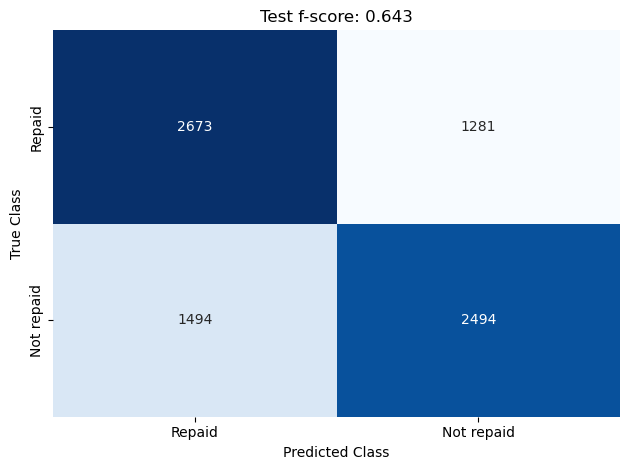

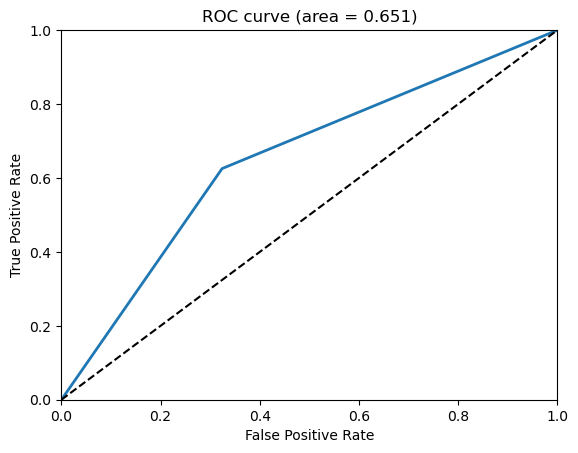

In [29]:
pretty_classification_report(test_model, X_train_val, y_train_val, class_names=['Repaid', 'Not repaid'], how='test')

In [32]:
! mkdir models

In [33]:
# dump using joblib
joblib.dump(test_model, os.path.join('models', 'test_model.joblib'))

['models/test_model.joblib']

In [36]:
# params which are equal for all runs
random_forest_params = {
    'random_state': SEED,
    'n_jobs': -1,
}

def objective(trial):

    # hyperparameters

    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # model
    model = RandomForestClassifier(
        **random_forest_params,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    model.fit(X_train_train, y_train_train)
    y_pred = model.predict(X_train_val)
    score = train_scorer(model, X_train_val, y_train_val)

    return score

N_ITER = 300

In [37]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction='maximize', study_name='random_forest')
optuna.logging.set_verbosity(20)

study.optimize(objective, n_trials=N_ITER, callbacks=[OptunaProgressBar(N_ITER)], n_jobs=-1)

Score: 0.4940 (best - 0.4977, trial 281): 100%|██████████| 600/600 [1:39:56<00:00,  9.99s/it]


In [38]:
study.best_value

0.497742

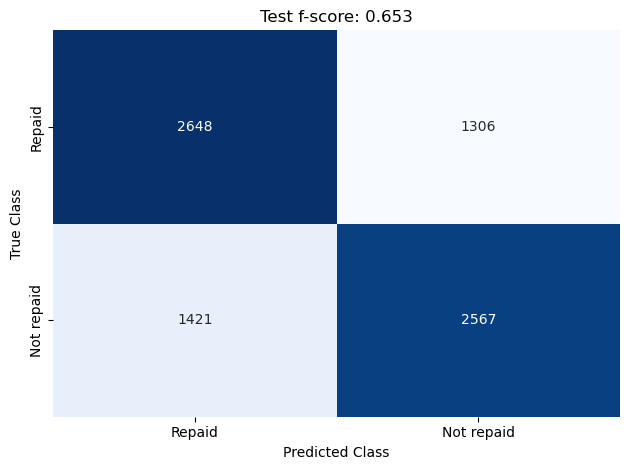

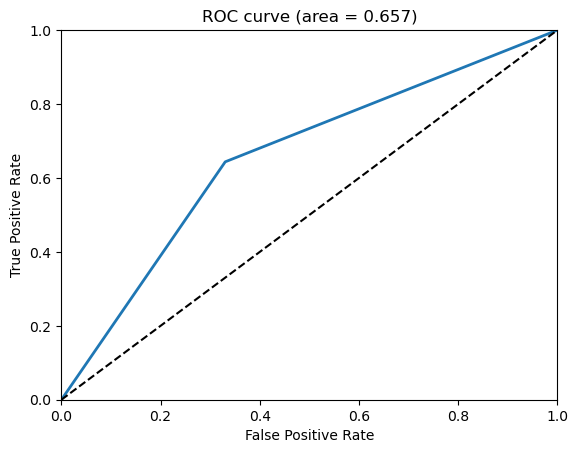

In [39]:
random_forest = get_estimator(random_forest_params, study, RandomForestClassifier)

random_forest.fit(X_train_train, y_train_train)

pretty_classification_report(random_forest, X_train_val, y_train_val, class_names=['Repaid', 'Not repaid'], how='test')

### Random forest without custom scorer

In [27]:
# params which are equal for all runs
random_forest_params = {
    'random_state': SEED,
    'n_jobs': -1,
}

def objective(trial):

    # hyperparameters

    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # model
    model = RandomForestClassifier(
        **random_forest_params,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    model.fit(X_train_train, y_train_train)
    y_pred = model.predict(X_train_val)
    score = f1_score(y_train_val, y_pred)

    return score

N_ITER = 100

In [28]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction='maximize', study_name='random_forest')
optuna.logging.set_verbosity(20)

study.optimize(objective, n_trials=N_ITER, callbacks=[OptunaProgressBar(N_ITER)], n_jobs=-1)

Score: 0.6534 (best - 0.6551, trial 78): 100%|██████████| 200/200 [25:39<00:00,  7.70s/it]


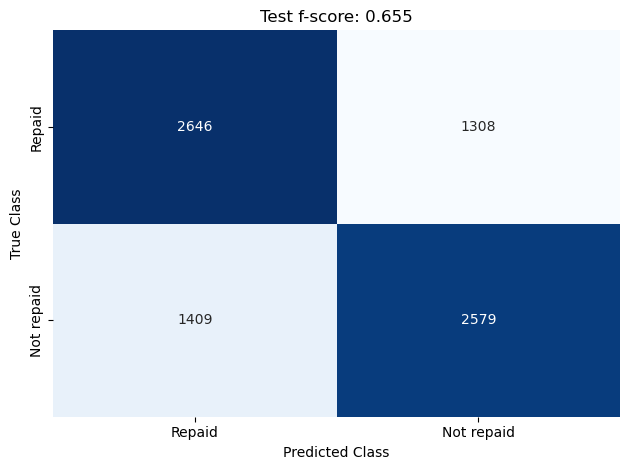

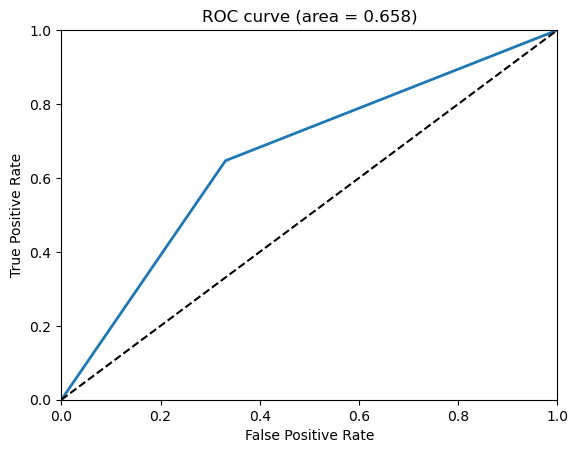

In [29]:
best_params = {'n_estimators': 417, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}

random_forest = RandomForestClassifier(**random_forest_params, **best_params)

random_forest.fit(X_train_train, y_train_train)

pretty_classification_report(random_forest, X_train_val, y_train_val, class_names=['Repaid', 'Not repaid'], how='test')

### Support vector machine

If polynomial kernel will be good, we will add polynomial features to the pipeline.

In [40]:
# params which are equal for all runs
svc_params = {
    'random_state': SEED,
    'probability': True,
    'kernel': 'poly'
}

def objective(trial):

    # hyperparameters
    C = trial.suggest_float('C', 1e-10, 1e10, log=True)

    # model
    model = SVC(
        **svc_params,
        C=C
    )
    
    model.fit(X_train_train, y_train_train)
    y_pred = model.predict(X_train_val)
    score = f1_score(y_train_val, y_pred)

    return score

N_ITER = 50

In [ ]:
optuna.logging.set_verbosity(20)
study = optuna.create_study(direction='maximize', study_name='svc')

study.optimize(objective, n_trials=N_ITER, callbacks=[OptunaProgressBar(N_ITER)], n_jobs=-1)

It's too slow to tune SVC...

### Feature importance

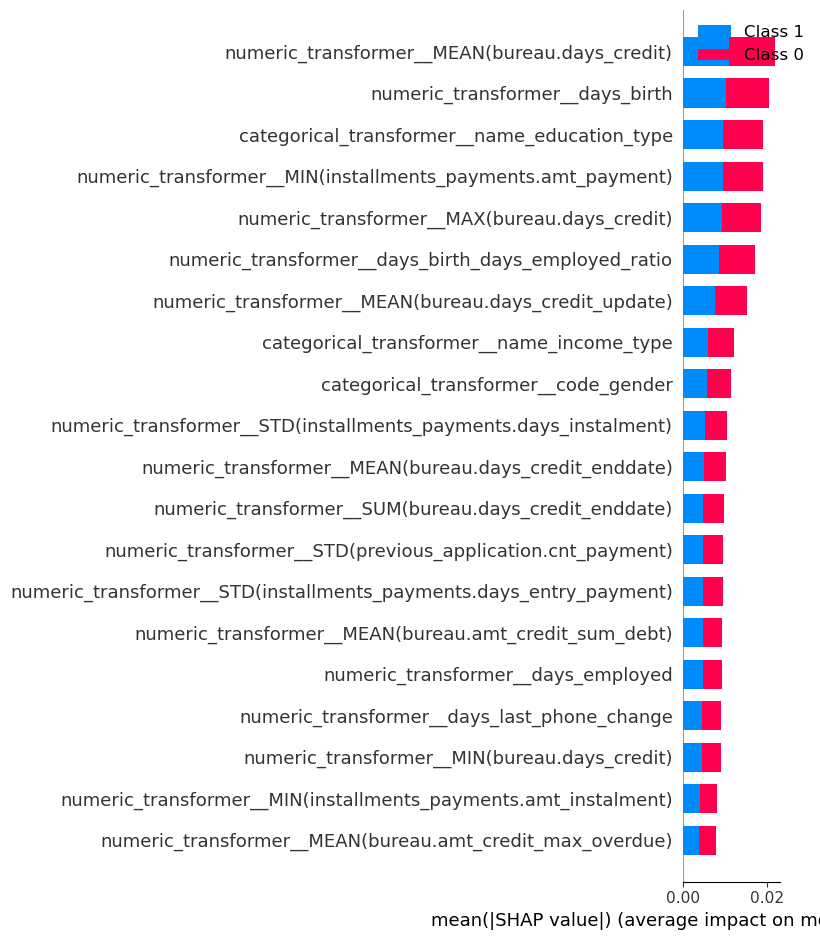

In [31]:
explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_train_val)
shap.summary_plot(shap_values, X_train_val, plot_type='bar')

### Conclusion

Taking into account the interest rate and not repaid sum of the loans, determined in EDA, ML models are not better than just always accept the application. Unfortunately, we don't have enough data to train a good model: tuning always converges to 0.5 and the model, which is very close to dummy classifier.

However, we can predict loan status (f-score 0.65). Polynomial features and further tuning can help to improve the model, but we have time and memory limitations on local machine.

Feautures, which were aggregated from the data about the previous credit history, are the most important. It's not surprising, because the previous credit history is the most important factor for the bank to decide whether to give a loan or not. We can adapt this aggregation for each client and use this information.W